# Imports

In [56]:
%matplotlib notebook

import matplotlib
import seaborn as sb
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import holoviews as hv

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pickle as pk
from time import time

import datetime
import sys

%matplotlib inline 
from IPython.display import display, HTML
from ipywidgets import widgets
from ipywidgets.widgets import interact, interactive, interactive_output, fixed 
from ipywidgets.widgets import IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, RadioButtons, Dropdown, Button, HBox, VBox

#  !pip3 install mpld3
# import mpld3
#pld3.enable_notebook() causes plotting to not work???

from scipy.integrate import odeint
# !pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

from time import time
import warnings
warnings.filterwarnings('ignore')
# JSM added
# from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from Cluster import * 

In [3]:
bd = BaseData('data_all_base')

reading in data from data_all_base ...
elapsed:  6.465733289718628


In [4]:
# run 
# clusdtypes should be in ['JRP1','ORP1','JWP1','OWP1','JRT1','ORT1','JWT1','OWT1']
# database JHU/OWID  (J/O) 
# report_correct T or F   (R/W)
# syncat peak/thresh  (P/T)
clusdtype='JRT1'
ClData = get_cluster_data(clusdtype)

reading in data from ./pks/data_cluster_JRT1.pk ...


In [5]:
exec(open('ClusterFit.py','r').read())

In [6]:
# changed to use model_fits_age : this is backwards compatible and only loads data if needed
# neither model_fits.py nor model_fits_nodata.py now required
# from model_fits_nodata import *  # including ModelFit class definition.
import data_config
data_config.data_loaded = True    
from model_fits_age import *  # including ModelFit class definition. 

data already loaded, so no "from data import *" required.
making the models...
SEI3R
SC3EI3R
SC3UEI3R
done with the models.


In [7]:
# eliminate countries with no population data (needed for normalizing death stats for fits)

#for country in countries:
#    if population_owid[country][0] == 0:
#        print(country)
        
countries = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] > 0]
print(len(countries),'countries with population data')
countries_zp = [cc for cc in bd.countries_common if bd.population_owid[cc][-2] == 0]
print('common countries without population data',countries_zp)
cluster_countries = [c for c in ClData.clusdata_all['deaths']]
print(len(cluster_countries),'cluster countries')


187 countries with population data
common countries without population data []
87 cluster countries


**Consensus clustering and map**

In [8]:
# from Consensus import *
# NB:  scoping problem seems to prevent import from working properly.
# instead use exec below.
country_display = None
class_display = None
display_countries = None
chosen_country = 'Australia'
chosen_class = -1
geog = None
geog1 = None
exec(open('Consensus.py','r').read());

In [9]:
#foo = Consensus(cases=['deaths','cases','cases_nonlinr'])
clus = Consensus(ClData,cases = ['deaths', 'cases', 'cases_nonlinr']);


87 countries
reference clustering (numbered from 0) is 11


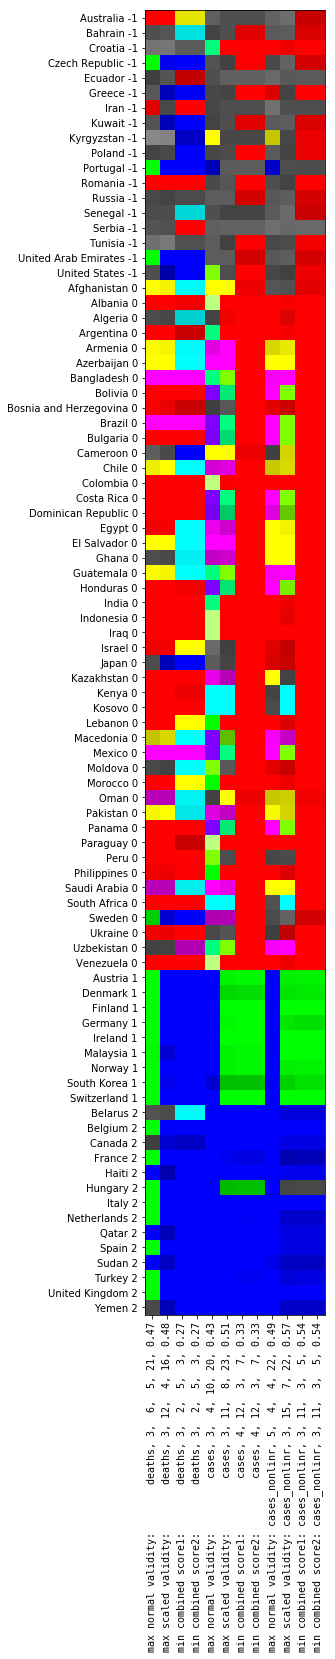

In [10]:
clus.scan()
clus.make_clusters()
clus.swizzle()
clus.plot_swiz()
chosen_swdic = clus.swdic

In [11]:
import io

classes = sprintdic(clus.swdic,chosen_country='Australia',chosen_class=-1)
class_display = widgets.Textarea(value=classes,layout = widgets.Layout(height='280px'))

In [12]:
def cluster_trace(cons, dataname='deaths',country='Australia'):
    try:
        if country in cons.countries:
            plt.plot(cons.cldata.clusdata_all[dataname][country])
    except:
        plt.plot(cons.cldata.clusdata_all[dataname]['Australia'])
display_countries = clus.countries        
country_display = interactive(cluster_trace,cons=fixed(clus),dataname=clus.cases,country=clus.countries);

In [13]:
#display(country_display)
clus.make_map();

In [14]:
clus.map;
clus.map.min_height=600;

In [39]:
bd.countries_common
print(bd.covid_owid_ts.keys())
bd.covid_owid_ts.keys()

dict_keys(['confirmed', 'deaths', 'recovered', 'tests', 'stringency', 'population', 'population_density', 'gdp_per_capita', 'new_deaths', 'new_deaths_smoothed', 'deaths_smoothed', 'new_deaths_corrected', 'new_deaths_corrected_smoothed', 'deaths_corrected_smoothed', 'new_confirmed', 'new_confirmed_smoothed', 'confirmed_smoothed', 'new_confirmed_corrected', 'new_confirmed_corrected_smoothed', 'confirmed_corrected_smoothed', 'new_confirmed_linr_corrected_smoothed', 'confirmed_linr_corrected_smoothed', 'new_confirmed_nonlin_corrected_smoothed', 'confirmed_nonlin_corrected_smoothed', 'new_confirmed_nonlinr_corrected_smoothed', 'confirmed_nonlinr_corrected_smoothed'])


dict_keys(['confirmed', 'deaths', 'recovered', 'tests', 'stringency', 'population', 'population_density', 'gdp_per_capita', 'new_deaths', 'new_deaths_smoothed', 'deaths_smoothed', 'new_deaths_corrected', 'new_deaths_corrected_smoothed', 'deaths_corrected_smoothed', 'new_confirmed', 'new_confirmed_smoothed', 'confirmed_smoothed', 'new_confirmed_corrected', 'new_confirmed_corrected_smoothed', 'confirmed_corrected_smoothed', 'new_confirmed_linr_corrected_smoothed', 'confirmed_linr_corrected_smoothed', 'new_confirmed_nonlin_corrected_smoothed', 'confirmed_nonlin_corrected_smoothed', 'new_confirmed_nonlinr_corrected_smoothed', 'confirmed_nonlinr_corrected_smoothed'])

In [90]:
country_display.children[1].value

'Canada'

In [91]:
countries_common = bd.countries_common  
datasrcs_widget = RadioButtons(options=['jhu','owid'],description='data source',disabled=False) 
datanames_widget = Dropdown(options=list(bd.covid_ts.keys()),description='data choice',disabled=False,layout={'width': 'max-content'}) 
countries_widget = Dropdown(options=countries_common,description='countries',layout={'width': 'max-content'}) 

def datanames_update(*args):
    if datasrcs_widget.value == 'jhu':
        datanames_widget.options = list(bd.covid_ts.keys())
    elif datasrcs_widget.value == 'owid':
        datanames_widget.options = list(bd.covid_owid_ts.keys()) 
datanames_widget.observe(datanames_update,'options')

def countries_update(*args):
    global chosen_country,countries_common
    #if chosen_country in countries_common:
    countries_widget.value = country_display.children[1].value
    # else:
    # countries_widget.value = countries_widget.value
country_display.children[1].observe(countries_update,'value')

def common_trace(datasrc = 'jhu', dataname='deaths',country='Australia'):
    global bd,countries_common
    if country in countries_common:
        if datasrc == 'jhu':
            if dataname in bd.covid_ts:
                plt.plot(bd.covid_ts[dataname][country])
            else:
                print('dataname not found',dataname)
        elif datasrc == 'owid':
            if dataname in bd.covid_owid_ts:
                plt.plot(bd.covid_owid_ts[dataname][country])
            else:
                print('dataname not found',dataname)
        else:
            print('Error in datasrc')
            
country_display_trace = interactive_output(common_trace,{'datasrc':datasrcs_widget,'dataname':datanames_widget,'country':countries_widget});

In [92]:
cbox = VBox([datasrcs_widget,datanames_widget,countries_widget,country_display_trace])  
mybox = HBox([country_display,class_display,cbox])
VBox([mybox,clus.map])    

**Some preliminary data plots**

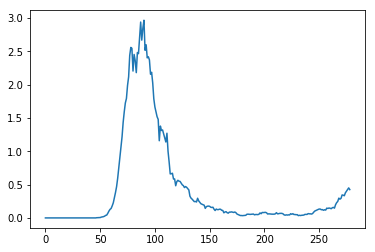

In [9]:
plt.plot(bd.new_deaths_spm_jhu['Germany'])

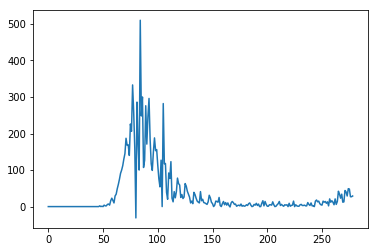

In [10]:
plt.plot(bd.covid_ts['new_deaths']['Germany'])

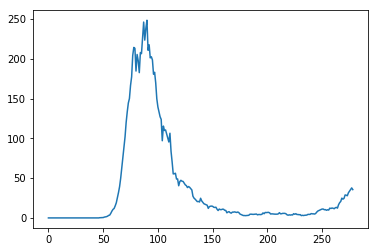

In [11]:
plt.plot(bd.covid_ts['new_deaths_smoothed']['Germany'])

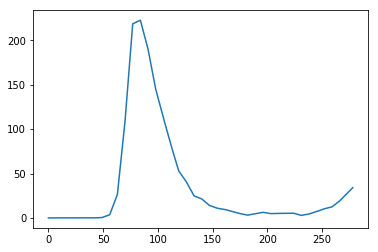

In [12]:
plt.plot(bd.covid_ts['new_deaths_corrected_smoothed']['Germany'])

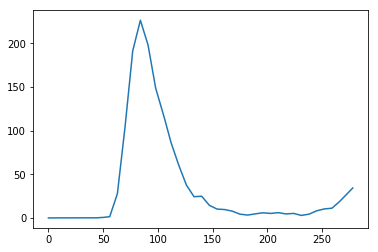

In [13]:
plt.plot(bd.covid_owid_ts['new_deaths_corrected_smoothed']['Germany'])

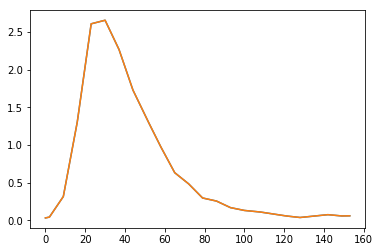

In [14]:
plt.plot(ClData.clusdata_all['deaths']['Germany'])
plt.plot(ClData.deaths_raw['Germany']);

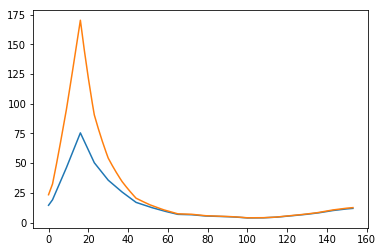

In [15]:
plt.plot(ClData.clusdata_all['cases']['Germany'])
plt.plot(ClData.clusdata_all['cases_nonlinr']['Germany']);

In [17]:
[x for x in dir(ClData) if '__' not in x]

['CaCo',
 'K',
 'bcountries',
 'bcountries_1',
 'big',
 'big_cases',
 'big_testing_c',
 'cases_adj_lin2020',
 'cases_adj_nonlin',
 'cases_adj_nonlinr',
 'cases_adj_pwlfit',
 'cases_raw',
 'clusdata_all',
 'clusdata_len',
 'clusdtype',
 'cluster_data',
 'cluster_data_loaded',
 'countries_common',
 'daily_deaths',
 'database',
 'datasets',
 'daysync',
 'deaths_raw',
 'first_peak',
 'first_thresh',
 'lccountries',
 'lcountries',
 'longshort',
 'longshort_c',
 'longshort_cases',
 'longshort_cases_c',
 'longshort_cases_est',
 'longshort_reg_testing_c',
 'longshort_testing_c',
 'longshortest',
 'make_cases_adj_nonlin',
 'mindays',
 'mindeaths',
 'mindeathspm',
 'new_cases_spm',
 'new_deaths_spm',
 'reg_testing_lc',
 'regtests',
 'report_correct',
 'short_cases',
 'short_cases_c',
 'short_cases_est',
 'short_deaths',
 'short_deaths_c',
 'short_deaths_est',
 'short_reg_testing',
 'short_reg_testing_c',
 'short_reg_testing_est',
 'short_testing',
 'short_testing_c',
 'short_testing_est',
 'sync

In [16]:
[x for x in ClData.clusdata_all if '__' not in x]

['deaths',
 'cases',
 'cases_lin2020',
 'cases_pwlfit',
 'cases_nonlin',
 'cases_nonlinr']

# Use `Modelfit.solvefit()` with `lmfit`

In [24]:
bd = BaseData('data_all_base')

reading in data from data_all_base ...
elapsed:  7.523547887802124


In [25]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
# exec(open('model_fits_nodata.py','r').read())
exec(open('ModelFit.py','r').read())

In [28]:
# check that now all country names are strings : jhu data now only has common countries (191)
ts=bd.covid_ts
ts.keys()
for dt in ts.keys():
    if 'Germany' in ts[dt].keys():
        print(dt,'str')
    elif ('Germany','') in ts[dt].keys():
        print(dt,"(str,'')")
    else:
        print(dt,'no country key')

confirmed str
deaths str
recovered str
new_deaths str
new_deaths_smoothed str
deaths_smoothed str
new_deaths_corrected str
new_deaths_corrected_smoothed str
deaths_corrected_smoothed str
new_confirmed str
new_confirmed_smoothed str
confirmed_smoothed str
new_confirmed_corrected str
new_confirmed_corrected_smoothed str
confirmed_corrected_smoothed str
new_confirmed_linr_corrected_smoothed str
confirmed_linr_corrected_smoothed str
new_confirmed_nonlin_corrected_smoothed str
confirmed_nonlin_corrected_smoothed str
new_confirmed_nonlinr_corrected_smoothed str
confirmed_nonlinr_corrected_smoothed str


In [32]:
country = 'Germany'
###############################################
## do the fit
#MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_ts,country=country,run_id="_test1",data_src='jhu')

In [33]:
# restricted range:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}

params_init_min_max = {
                   "beta_1": (0.4, 0.0, 0.8,0.001),
                   "mu": (.05,0.0,0.15,0.001),
                   "c_0": (0.1, 0.0, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 15., 0.01), 
                   "logI_0": (-6.,-11.,-3.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [34]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [35]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)

# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  2.2440168857574463
Param beta_1 witihin 0.0 % of max.
Param c_0 within 1.11 % of min.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 105
    # data points      = 279
    # variables        = 6
    chi-square         = 0.66693541
    reduced chi-square = 0.00244299
    Akaike info crit   = -1672.12041
    Bayesian info crit = -1650.33314
[[Variables]]
    beta_1:  0.79998458 +/- 0.08284656 (10.36%) (init = 0.4)
    mu:      0.01406379 +/- 0.03289754 (233.92%) (init = 0.05)
    c_0:     0.01113968 +/- 0.17698921 (1588.82%) (init = 0.1)
    c_1:     0.00539250 +/- 0.00165250 (30.64%) (init = 0.07)
    c_2:     3.20148469 +/- 8.01500712 (250.35%) (init = 5)
    logI_0: -9.44187894 +/- 0.96708919 (10.24%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_2, logI_0)    = -0.998
    C(mu, c_2)        =  0.998
    C(mu, logI_0)     = -0.997
    C(c_1, c_2)       = -0.959
    C(c_1, logI_0)    =  0.953
    C(c_0, c_1)       

In [36]:
start = time()
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
print('Elapsed: ',time()-start)

elapsed time =  1.4188849925994873
Param beta_1 witihin 4.13 % of max.
Param c_0 within 3.61 % of min.
Param c_2 witihin 0.0 % of max.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 140
    # data points      = 558
    # variables        = 6
    chi-square         = 4.28386345
    reduced chi-square = 0.00776062
    Akaike info crit   = -2705.18306
    Bayesian info crit = -2679.23690
[[Variables]]
    beta_1:  0.76692352 +/- 0.01090790 (1.42%) (init = 0.4)
    mu:      0.07986784 +/- 0.00244813 (3.07%) (init = 0.05)
    c_0:     0.03605496 +/- 0.05015336 (139.10%) (init = 0.1)
    c_1:     0.01143873 +/- 0.00110254 (9.64%) (init = 0.07)
    c_2:     14.9999020 +/- 3.37096224 (22.47%) (init = 5)
    logI_0: -9.99126807 +/- 0.06083477 (0.61%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, logI_0) = -0.976
    C(c_0, c_2)       = -0.949
    C(beta_1, c_2)    = -0.477
    C(c_2, logI_0)    =  0.426
    C(c_1, c_2)       = -0.

In [38]:
MyModel.checkparams(params_init_min_max)

Param beta_1 witihin 4.13 % of max.
Param c_0 within 3.61 % of min.
Param c_2 witihin 0.0 % of max.


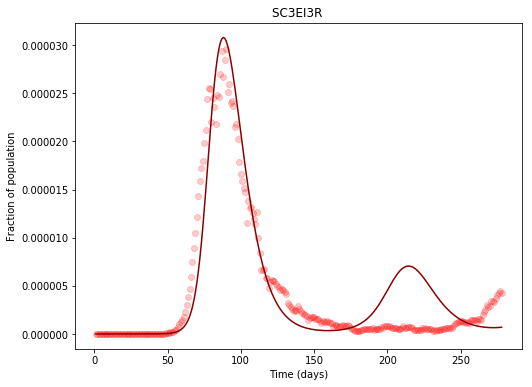

In [39]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

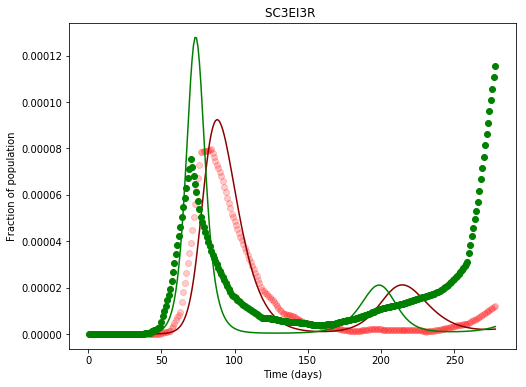

In [40]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

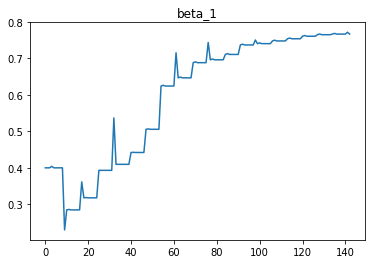

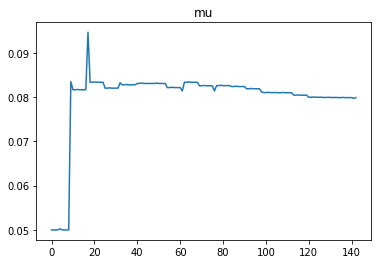

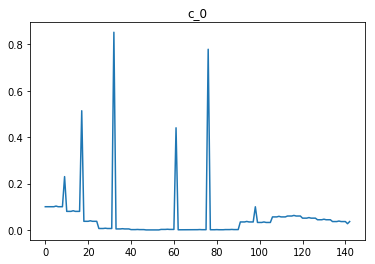

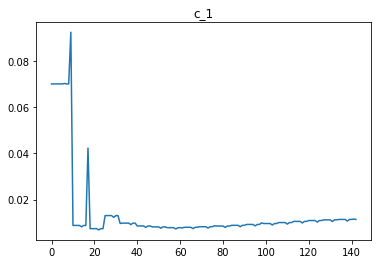

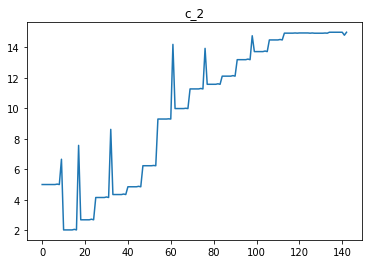

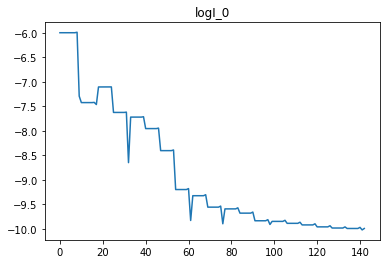

In [41]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

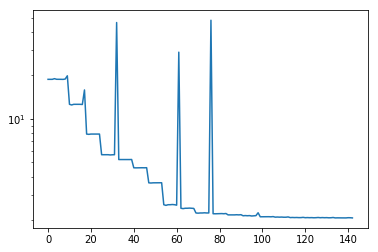

In [42]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

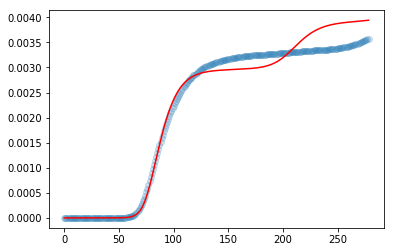

In [43]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

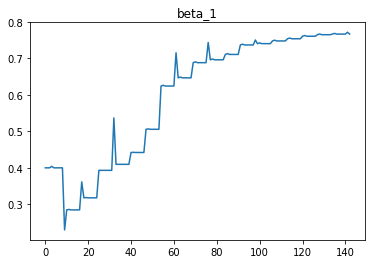

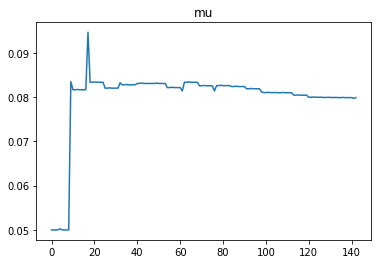

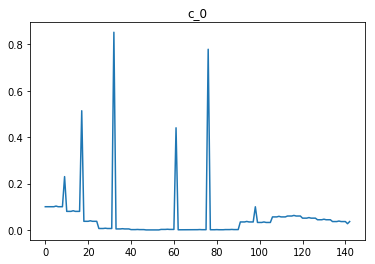

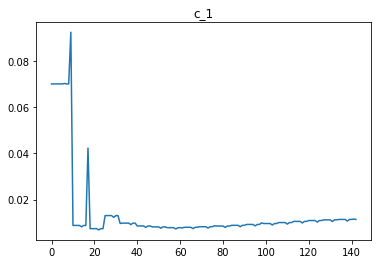

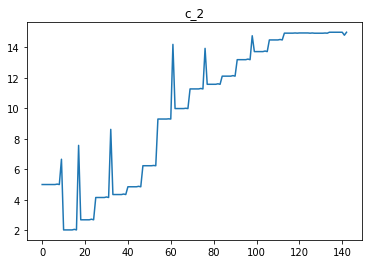

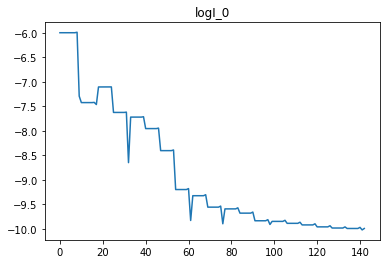

In [44]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

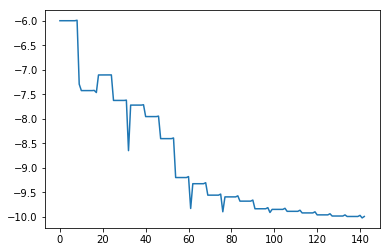

In [45]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

In [46]:
# outfit.params
MyModel.params

{'beta_1': 0.7669235222499288,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.07986783929591006,
 'c_0': 0.036054964406739165,
 'c_1': 0.01143872724188677,
 'c_2': 14.999902045775597,
 'N': 1}

## Trying solve4fitlog 

In [47]:
country = 'Germany'
###############################################
## do the fit
#MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_ts,country=country,run_id="_test1",data_src='jhu')

In [48]:
params_init_min_max = {
                   "beta_1": (0.4, 0.0, 0.8,0.001),
                   "mu": (.05,0.0,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                   "logI_0": (-6.,-9.,-3.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [49]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [50]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  2.2083821296691895
Param beta_1 witihin 0.01 % of max.
Param mu within 3.0 % of min.
Param c_0 within 0.04 % of min.
Param c_2 within 2.07 % of min.
Param logI_0 within 0.76 % of min.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 105
    # data points      = 279
    # variables        = 6
    chi-square         = 0.67551710
    reduced chi-square = 0.00247442
    Akaike info crit   = -1668.55332
    Bayesian info crit = -1646.76604
[[Variables]]
    beta_1:  0.79995356 +/- 0.00995794 (1.24%) (init = 0.4)
    mu:      0.00450240 +/- 0.03296765 (732.22%) (init = 0.05)
    c_0:     0.05040545 +/- 0.23687990 (469.95%) (init = 0.1)
    c_1:     0.00551105 +/- 0.00246750 (44.77%) (init = 0.07)
    c_2:     1.14519735 +/- 8.42676421 (735.84%) (init = 5)
    logI_0: -8.95435697 +/- 0.74269524 (8.29%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, c_2)        =  1.000
    C(c_2, logI_0)    = -1.000
    C(mu, logI_0)   

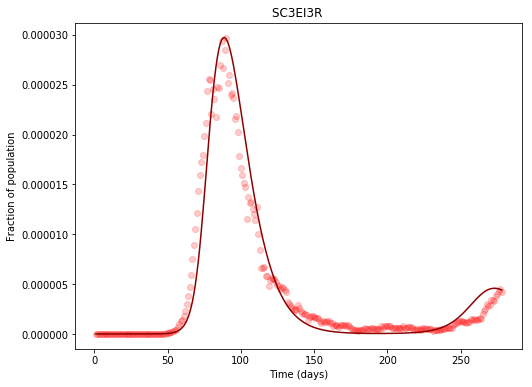

In [51]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

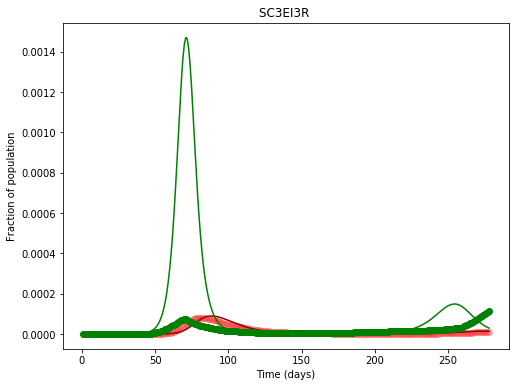

In [52]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

In [53]:
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  8.673433065414429
Param c_0 within 0.06 % of min.
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 873
    # data points      = 558
    # variables        = 6
    chi-square         = 77.6356290
    reduced chi-square = 0.14064426
    Akaike info crit   = -1088.56154
    Bayesian info crit = -1062.61538
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.29569857 +/- 0.00268035 (0.91%) (init = 0.4)
    mu:      0.07248698 +/- 7.8052e-04 (1.08%) (init = 0.05)
    c_0:     0.05060487 +/-        nan (nan%) (init = 0.1)
    c_1:     0.01046716 +/-        nan (nan%) (init = 0.07)
    c_2:     2.35887046 +/-        nan (nan%) (init = 5)
    logI_0: -6.76317149 +/-        nan (nan%) (init = -6)


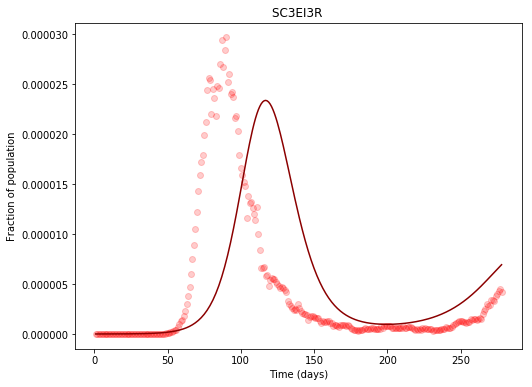

In [54]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

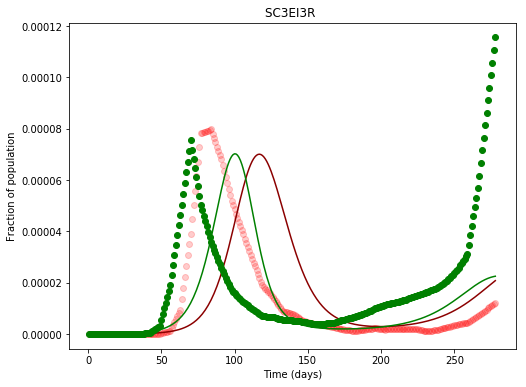

In [55]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

### SEI3R

In [56]:
country = 'Germany'
###############################################
## do the fit
#MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
MyModel = ModelFit('SEI3R',basedata=bd,data=bd.covid_ts,country=country,run_id="_test1",data_src='jhu')

In [57]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.8,0.001),
                   "mu": (.05,0.0,0.15,0.001),
                   #"c_0": (0.1, 0.05, 1.0,0.001), 
                   #"c_1": (0.07, 0.0, 0.1,0.001),
                   #"c_2": (5., 1., 8., 0.01), 
                   "logI_0": (-6.,-9.,-3.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [58]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'N': 1}

In [59]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  1.25472092628479
Param beta_1 witihin 0.51 % of max.
Param mu within 0.07 % of min.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 279
    # variables        = 3
    chi-square         = 2.34883966
    reduced chi-square = 0.00851029
    Akaike info crit   = -1326.86400
    Bayesian info crit = -1315.97037
[[Variables]]
    beta_1:  0.79744079 +/- 0.02919025 (3.66%) (init = 0.4)
    mu:      1.0271e-04 +/- 1.3646e-06 (1.33%) (init = 0.05)
    logI_0: -7.69175247 +/- 0.01546410 (0.20%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, logI_0) =  0.992
    C(beta_1, mu)     = -0.190
    C(mu, logI_0)     = -0.135


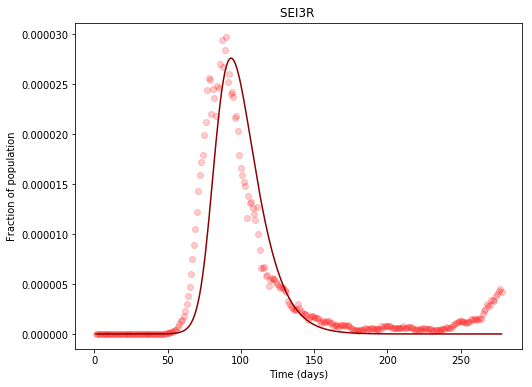

In [60]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

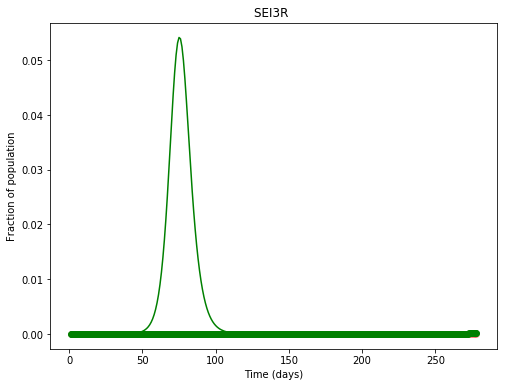

In [61]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

In [62]:
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  1.1576530933380127
Param beta_1 within 0.0 % of min.
Param mu within 0.97 % of min.
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 263
    # data points      = 558
    # variables        = 3
    chi-square         = 1272.47172
    reduced chi-square = 2.29274183
    Akaike info crit   = 465.991519
    Bayesian info crit = 478.964596
[[Variables]]
    beta_1:  0.30000000 +/- 2.3394e-06 (0.00%) (init = 0.4)
    mu:      0.00145113 +/- 3.7560e-04 (25.88%) (init = 0.05)
    logI_0: -6.74923774 +/- 0.05073834 (0.75%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, logI_0) = -0.205


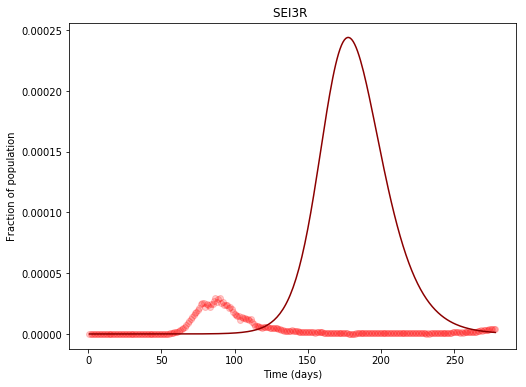

In [63]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

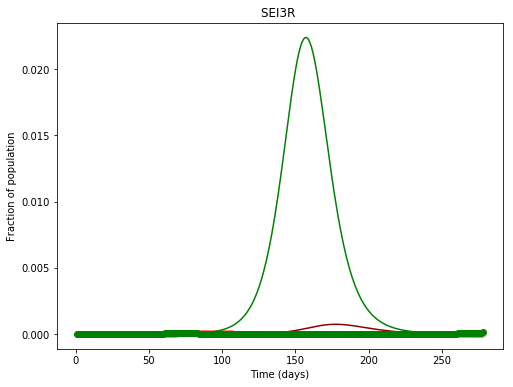

In [64]:
MyModel.solveplot(['deaths','confirmed'],
                  datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],
                  mag={'deaths':30.})

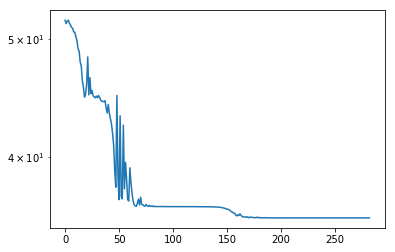

In [65]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

['beta_1', 'mu', 'logI_0']


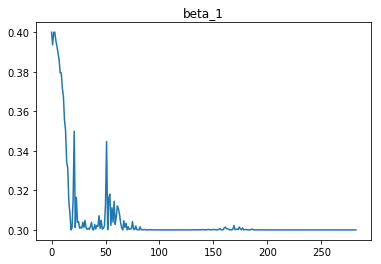

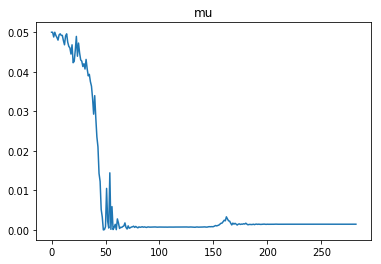

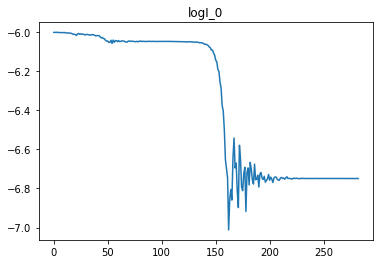

In [66]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
print(pars)
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [67]:
MyModel.prparams()

params:
{'N': 1,
 'alpha': 0.2,
 'beta_1': 0.3000000009973069,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'mu': 0.0014511287781041936,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333}
sbparams:
{'CFR': 0.0014303722349685531,
 'DurHosp': 4.0,
 'DurMildInf': 10.0,
 'Exposure': 0.3000000009973069,
 'FracCritical': 0.23333333333333328,
 'FracMild': 0.6999999999999998,
 'ICUFrac': 0.001,
 'IncubPeriod': 5.0,
 'TimeICUDeath': 9.856962776503146,
 'logI_0': -6.749237738574804}
pfbarams:
{'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0}
cbparams:
{'CautionExposure': None,
 'CautionExposureYoung': None,
 'CautionFactor': None,
 'CautionRetention': None,
 'EconomicCostOfCaution': None,
 'EconomicRetention': None,
 'EconomicStriction': None,
 'EconomyRelaxation': None}
dbparams:
{'country': 'Germany', 'data_src': 'owid', 'run_name': 'SEI3R'}
initial_values:
(array([9.99999822e-01, 0.00000000e+00, 1.78140334e-07, 0.000

In [68]:
np.power(10,3)

1000

## Trying different fitting methods...

see [lmfit documentation](https://lmfit.github.io/lmfit-py/fitting.html) on fitting methods for the list.

In this section I am using the same basic template to repeat the basic fitting operation with different fitting methods.

All seem to work.  Some comments:
* some (e.g. leastsq, differential_evolution) seem to hop all over the place, giving wildly varying residual socre and param convergence.
* some (powell, cobyla)seem to converge fast at beginning, with a slow tail (view residual plot with semilog)
* initially chose nelder, because of consistent gradual convergence.
* then switched back to leastsq as it gave fast reliable results after other problems had been resolved

## USA

### just deaths

NB: must do owid, key error with jhu

In [109]:
[x for x in bd.covid_ts['deaths'] if 'US' in x]

[('US', '')]

In [103]:
country = 'United States'
###############################################
## do the fit
#MyModel = ModelFit('SC3EI3R',basedata=bd,data=ClData.clusdata_all,country=country,run_id="_test1",data_src='cluster')
MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_ts,country=country,run_id="_test1",data_src='owid')

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_test1.pk :
problem with confirmed country United States
'United States'
problem with deaths country United States
'United States'
problem with recovered country United States
'United States'
problem with new_deaths country United States
'United States'
problem with new_deaths_smoothed country United States
'United States'
problem with deaths_smoothed country United States
'United States'
problem with new_deaths_corrected country United States
'United States'
problem with new_deaths_corrected_smoothed country United States
'United States'
problem with deaths_corrected_smoothed country United States
'United States'
problem with new_confirmed country United States
'United States'
problem with new_confirmed_smoothed country United States
'United States'
problem with confirmed_smoothed country United States
'United States'
problem with new_confirmed_corrected country United States
'U

In [61]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   #"mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   #"c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [62]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [90]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

#MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths'],fit_data='default',diag=True,report=True,conf_interval=False)


# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  125.62835097312927
[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 494
    # data points      = 279
    # variables        = 4
    chi-square         = 2.1479e-07
    reduced chi-square = 7.8106e-10
    Akaike info crit   = -5846.76320
    Bayesian info crit = -5832.23835
[[Variables]]
    beta_1:  0.43924705 +/- 5.5789e-04 (0.13%) (init = 0.4)
    c_0:     0.22878668 +/- 9.8841e-04 (0.43%) (init = 0.1)
    c_1:     0.00518359 +/- 4.5430e-05 (0.88%) (init = 0.07)
    logI_0: -7.03051792 +/- 0.00681365 (0.10%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, c_0)    = -0.904
    C(beta_1, logI_0) = -0.751
    C(c_0, logI_0)    =  0.619
    C(c_0, c_1)       = -0.433


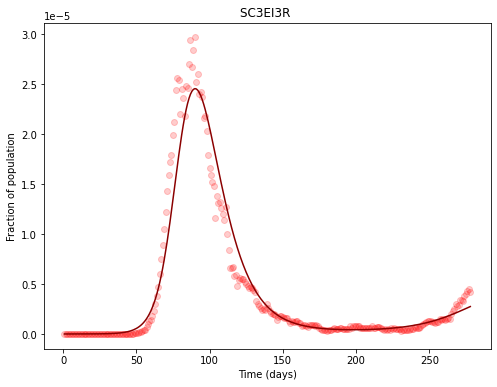

In [91]:
#MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
#MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])
#MyModel.solveplot(['confirmed'],datasets=['cases'])
MyModel.solveplot(['deaths'],datasets=['deaths'])

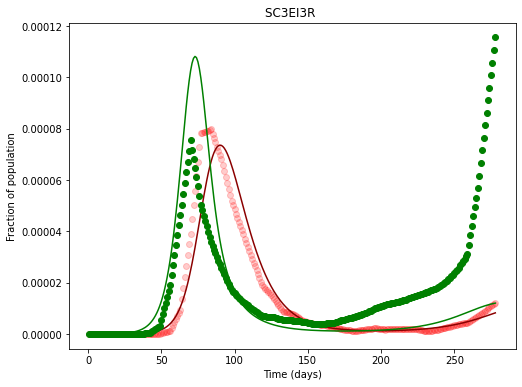

In [92]:
MyModel.solveplot(['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],mag={'deaths':30.})

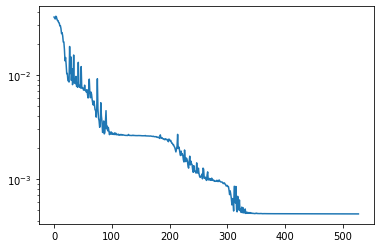

In [93]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

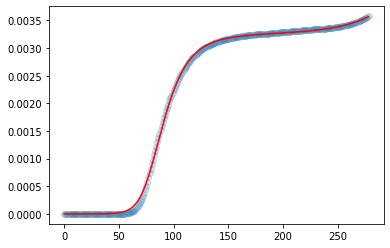

In [94]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [95]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'c_0', 'c_1', 'logI_0']

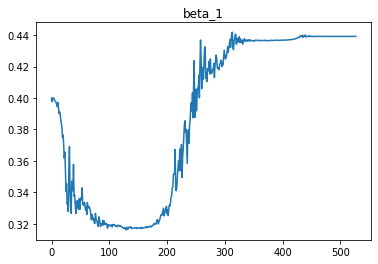

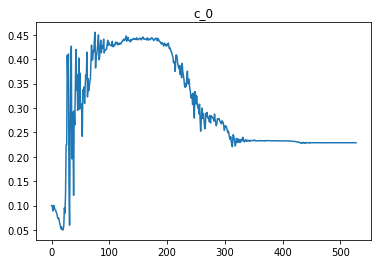

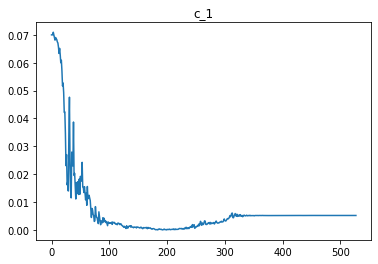

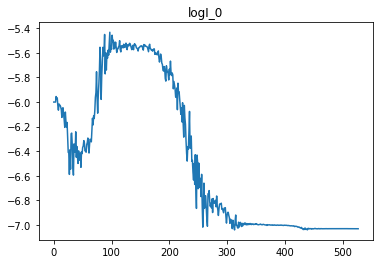

In [96]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

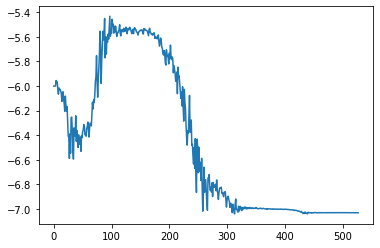

In [97]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

In [98]:
# outfit.params
MyModel.params

{'beta_1': 0.4392470520252808,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.22878667883971104,
 'c_1': 0.005183586131979146,
 'c_2': 5.0,
 'N': 1}

### fit deaths+confirmed

In [69]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',basedata=bd.covid_ts,country=country,run_id="_test1",data_src='owid')

Error:  must specify base data with arg basedata.
Error:  must specify data with arg data.


AttributeError: 'NoneType' object has no attribute 'population_owid'

In [29]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [30]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [31]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_nonlinr_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  3.848548173904419
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 241
    # data points      = 518
    # variables        = 6
    chi-square         = 0.00139337
    reduced chi-square = 2.7214e-06
    Akaike info crit   = -6631.86951
    Bayesian info crit = -6606.36965
[[Variables]]
    beta_1:  0.30001730 +/- 0.12910327 (43.03%) (init = 0.4)
    mu:      0.03790057 +/- 6.7712e-04 (1.79%) (init = 0.05)
    c_0:     0.54195963 +/- 0.09678630 (17.86%) (init = 0.1)
    c_1:     0.09983813 +/- 0.00929839 (9.31%) (init = 0.07)
    c_2:     7.92128573 +/- 7.33566092 (92.61%) (init = 5)
    logI_0: -5.20536724 +/- 1.05431648 (20.25%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_0, logI_0)    =  0.998
    C(beta_1, c_2)    =  0.997
    C(beta_1, c_0)    = -0.994
    C(beta_1, logI_0) = -0.993
    C(c_0, c_2)       = -0.984
    C(c_2, logI_0)    = -0.982
    C(c_0, c_1)       = -0.333
    C(c_1, logI_0)    = -0.326
   

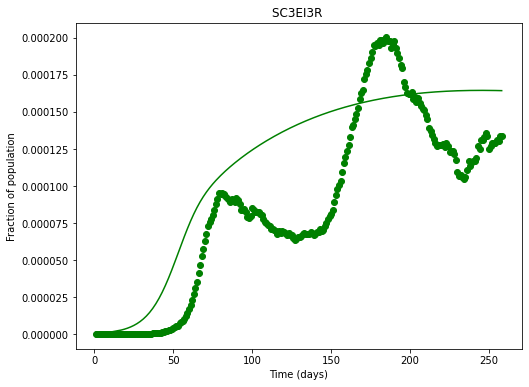

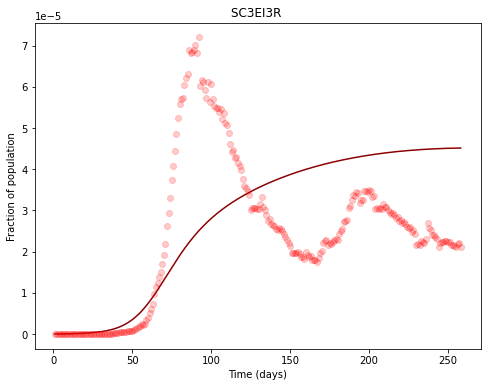

In [32]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

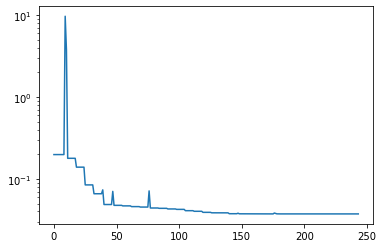

In [33]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

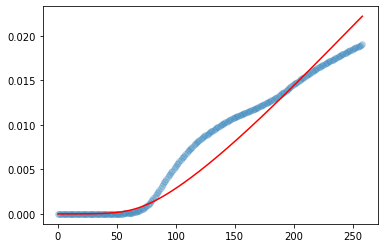

In [34]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [35]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

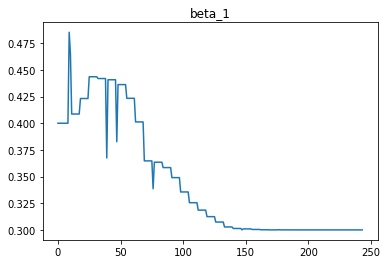

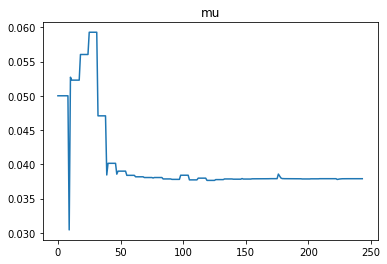

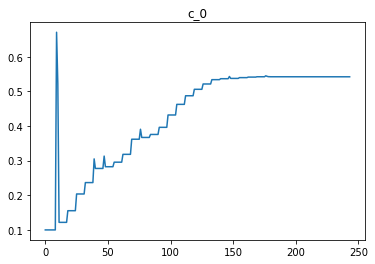

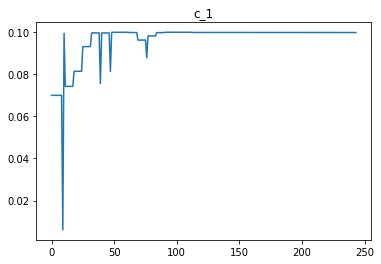

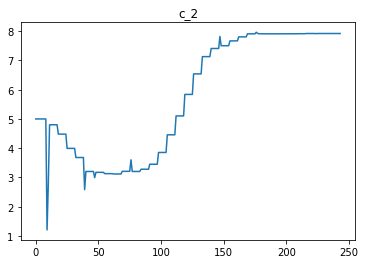

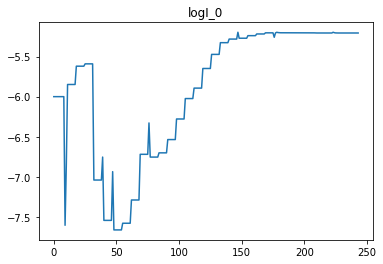

In [36]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

### fit deaths+ testing adjusted confirmed

In [37]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test1",data_src='owid')

loaded params from  /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_test1.pk :


In [38]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [39]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [40]:
testdata = covid_owid_ts['confirmed_corrected_smoothed']
print(len(testdata),len(testdata['United States']))
testdatar = covid_owid_ts['confirmed_nonlinr_corrected_smoothed']
print(len(testdatar),len(testdatar['United States']))


213 259
187 259


In [41]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_nonlinr_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  3.3424630165100098
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 241
    # data points      = 518
    # variables        = 6
    chi-square         = 0.00139337
    reduced chi-square = 2.7214e-06
    Akaike info crit   = -6631.86951
    Bayesian info crit = -6606.36965
[[Variables]]
    beta_1:  0.30001730 +/- 0.12910327 (43.03%) (init = 0.4)
    mu:      0.03790057 +/- 6.7712e-04 (1.79%) (init = 0.05)
    c_0:     0.54195963 +/- 0.09678630 (17.86%) (init = 0.1)
    c_1:     0.09983813 +/- 0.00929839 (9.31%) (init = 0.07)
    c_2:     7.92128573 +/- 7.33566092 (92.61%) (init = 5)
    logI_0: -5.20536724 +/- 1.05431648 (20.25%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_0, logI_0)    =  0.998
    C(beta_1, c_2)    =  0.997
    C(beta_1, c_0)    = -0.994
    C(beta_1, logI_0) = -0.993
    C(c_0, c_2)       = -0.984
    C(c_2, logI_0)    = -0.982
    C(c_0, c_1)       = -0.333
    C(c_1, logI_0)    = -0.326
  

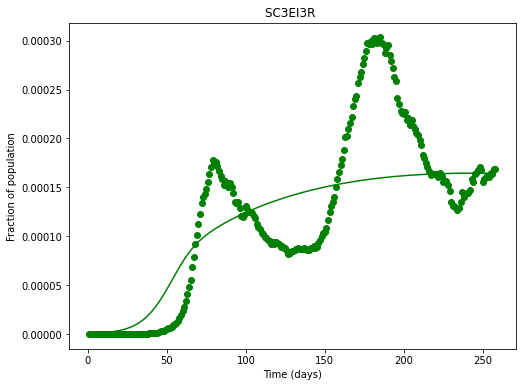

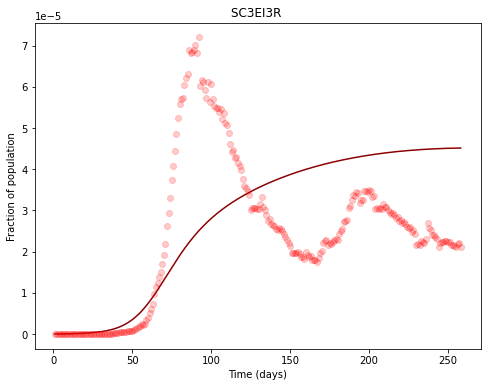

In [45]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_nonlinr_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

### fit deaths only

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

In [ ]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

# ModelFit with lmfit integrated

## SC3EI3R 

### Test on Germany with method Nelder

In [146]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [51]:
[x for x in bd.covid_owid_ts['deaths']]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 3.0,
 5.0,
 5.0,
 8.0,
 12.0,
 13.0,
 13.0,
 13.0,
 43.0,
 45.0,
 67.0,
 94.0,
 126.0,
 149.0,
 198.0,
 253.0,
 325.0,
 389.0,
 455.0,
 583.0,
 732.0,
 872.0,
 1017.0,
 1158.0,
 1342.0,
 1434.0,
 1607.0,
 1861.0,
 2107.0,
 2373.0,
 2544.0,
 2673.0,
 2799.0,
 2969.0,
 3254.0,
 3569.0,
 3868.0,
 4110.0,
 4294.0,
 4404.0,
 4598.0,
 4879.0,
 5094.0,
 5321.0,
 5500.0,
 5640.0,
 5750.0,
 5913.0,
 6115.0,
 6288.0,
 6481.0,
 6575.0,
 6649.0,
 6692.0,
 6831.0,
 6996.0,
 7119.0,
 7266.0,
 7369.0,
 7395.0,
 7417.0,
 7533.0,
 7634.0,
 7723.0,
 7824.0,
 7881.0,
 7914.0,
 7935.0,
 8007.0,
 8090.0,
 8147.0,
 8174.0,
 8216.0,
 8247.0,
 8257.0,
 8302.0,
 8349.0,
 8411.0,
 8450.0,
 8489.0,
 8500.0,
 8511.0,
 8522.

In [49]:
bd.covid_owid_ts['deaths']['dates'][-1]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [114]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_test2")

loaded params from  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test2.pk :


In [115]:
params_init_min_max = {"beta_1": (0.2, 0., 2.,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [116]:
MyModel.params

{'beta_1': 0.2,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.1,
 'c_0': 0.1,
 'c_1': 0.05,
 'c_2': 2.0,
 'N': 1}

In [117]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1145
    # data points      = 558
    # variables        = 6
    chi-square         = 4.6500e-05
    reduced chi-square = 8.4240e-08
    Akaike info crit   = -9083.62980
    Bayesian info crit = -9057.68365
[[Variables]]
    beta_1:  0.27571004 +/- 0.00326341 (1.18%) (init = 0.2)
    mu:      0.09117425 +/- 0.00134579 (1.48%) (init = 0.1)
    c_0:     0.17214340 +/- 0.00823295 (4.78%) (init = 0.1)
    c_1:     0.01077564 +/- 2.4993e-04 (2.32%) (init = 0.05)
    c_2:     3.37918676 +/- 0.07019867 (2.08%) (init = 2)
    logI_0: -5.66678068 +/- 0.04063812 (0.72%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, logI_0) = -0.786
    C(beta_1, c_2)    =  0.727
    C(c_2, logI_0)    = -0.491
    C(beta_1, c_0)    = -0.440
    C(c_0, logI_0)    =  0.431
    C(mu, c_0)        = -0.401
    C(mu, c_1)        = -0.320
    C(mu, c_2)        =  0.240
    C(beta_1, c_1)    = -0.220
    C(

Error:   ['deaths_corrected_smoothed'] not in data
Error:   ['confirmed_corrected_smoothed'] not in data


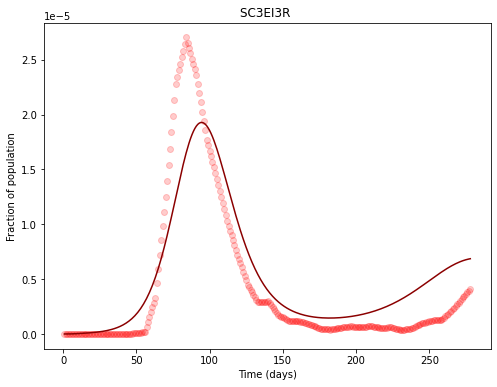

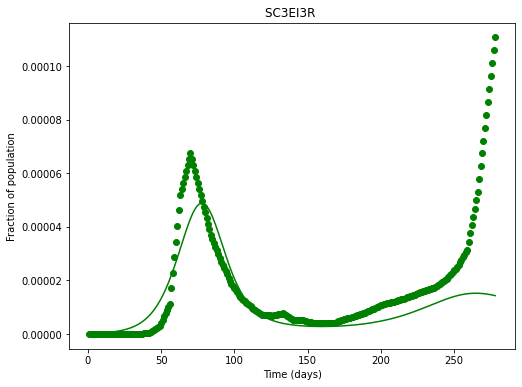

In [118]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

#### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
MyModel.prparams()

### Test on USA

In [119]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2",new=True)

Error:  must specify base data with arg basedata.


AttributeError: 'NoneType' object has no attribute 'population_owid'

In [ ]:
params_init_min_max = {"beta_1": (0.4, 0., 2.,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
countries[0]

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
params_init_min_max = {"beta_1": (0.2, 0.0, 2.0,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
MyModel.fit(params_init_min_max,fit_method=mymethod,diag=True,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.4, 0.1, 0.6),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
        MyModel.solveplot(species=['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [ ]:
params_init_min_max = {"beta_1": (0.4, 0, 2.0,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
MyModel.fit(params_init_min_max,fit_method=mymethod,diag=True,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

[[Variables]]
    beta_1:  0.32665845 +/- 0.46153068 (141.29%) (init = 0.2)
    mu:      0.09205437 +/- 0.06980213 (75.83%) (init = 0.1)
    c_0:     0.18519038 +/- 0.21390488 (115.51%) (init = 0.1)
    c_1:     0.16174352 +/- 0.16259196 (100.52%) (init = 0.05)
    c_2:     9.32518629 +/- 6.93746369 (74.39%) (init = 2)
    logI_0: -6.00779344 +/- 2.75916716 (45.93%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, c_0) = -0.441
    C(beta_1, c_2) =  0.229
    C(c_1, c_2)    =  0.225
    C(c_0, c_1)    =  0.124
    C(beta_1, mu)  = -0.108
    C(mu, c_0)     =  0.107

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [ ]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

In [ ]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

#### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
MyModel.prparams()

### Test Scan class

In [116]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [117]:
foo = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_scan",new=True,data_src='owid') # run_id labels parameter dump files



In [118]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']
short_countries = ['United States','Spain','Peru']

In [119]:
pinit = {"beta_1": (0.2, 0., 2.),
         "mu": (.1,0.,.2),
         "c_0": (0.1, 0., 1.0),
         "c_1": (0.07, 0.0, 0.5),
         "c_2": (5., 2.,20.),
         "logI_0": (-6.,-10.,0.0)}

foo = Scan(countries=short_countries,params_init_min_max=pinit, modelname='SC3EI3R',
           basedata=bd,data=bd.covid_owid_ts,country=country,run_id='_short',new=True,data_src='owid') # run_id labels parameter dump files



0 United States
1 Spain
2 Peru


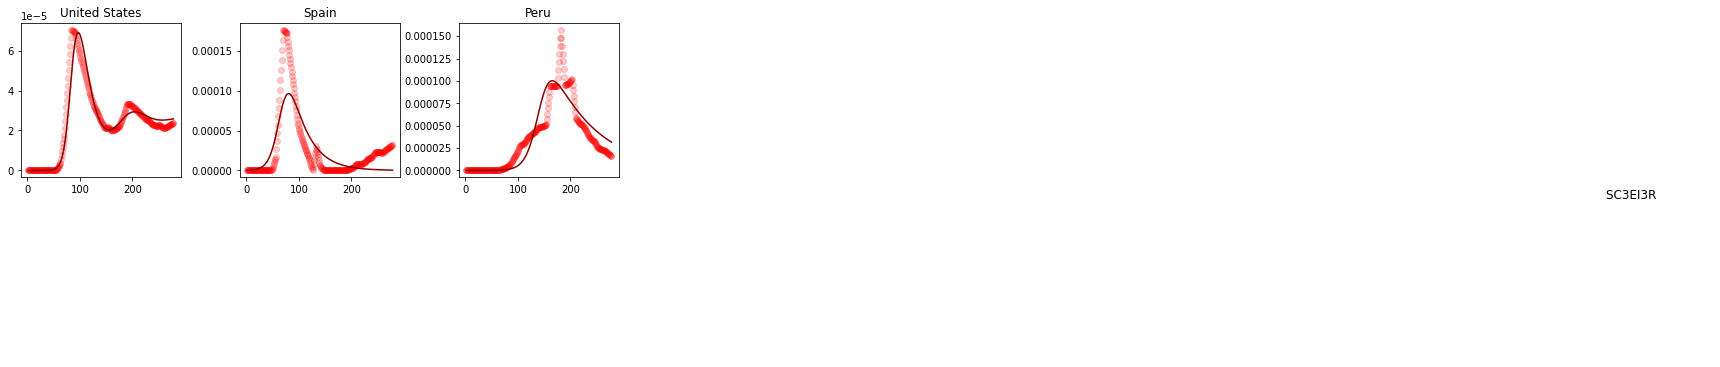

Total elapsed time for  187 countries: 141.58077788352966
Time per country: 0.7571164592702121


In [120]:
foo.scan()

In [ ]:
foo.run_id

### Country scan

**Deaths only**

In [126]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 112
    # data points      = 279
    # variables        = 6
    chi-square         = 7.2597e-05
    reduced chi-square = 2.6592e-07
    Akaike info crit   = -4218.14152
    Bayesian info crit = -4196.35424
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.36445713 +/-        nan (nan%) (init = 0.2)
    mu:      0.10687037 +/-        nan (nan%) (init = 0.1)
    c_0:     0.11387284 +/-        nan (nan%) (init = 0.1)
    c_1:     0.09011415 +/-        nan (nan%) (init = 0.07)
    c_2:     4.24385052 +/-        nan (nan%) (init = 5)
    logI_0: -6.14339902 +/-        nan (nan%) (init = -6)
[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 194
    # data points      = 279
    # variables        = 6
    chi-square         = 9.3662e-04
    reduced chi-square = 3.4308e-06
    Akaike info crit   = -3504.63960
    Bayesian info crit = -3482.85233
##  Warning: uncertai

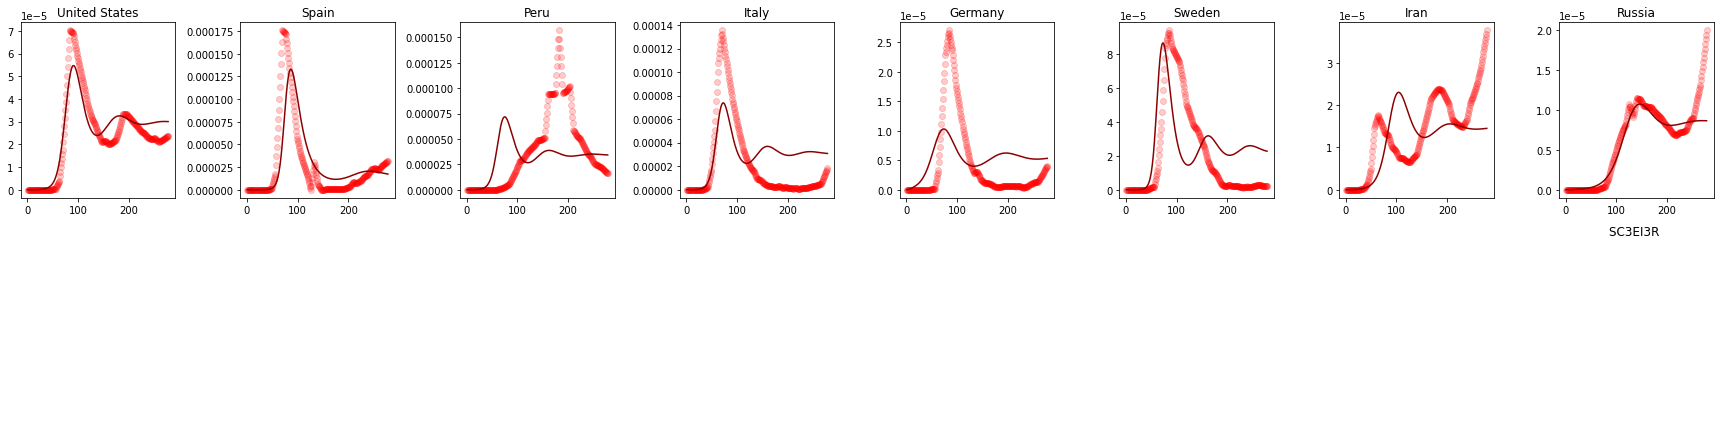

In [131]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        
        MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_scan",new=True,data_src='owid') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,fit_method='slsqp',diag=False,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])
        MyModel.solveplot(species=['deaths'],datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()

In [135]:
len(cluster_countries)

87

In [134]:
[x for x in dir() if 'countries' in x]

['cluster_countries', 'countries', 'countries_zp', 'short_countries']

**deaths only, graph confirmed with nonlinr corrected**

In [128]:
[x for x in bd.covid_owid_ts]

['confirmed',
 'deaths',
 'recovered',
 'tests',
 'stringency',
 'population',
 'population_density',
 'gdp_per_capita',
 'new_deaths',
 'new_deaths_smoothed',
 'deaths_smoothed',
 'new_deaths_corrected',
 'new_deaths_corrected_smoothed',
 'deaths_corrected_smoothed',
 'new_confirmed',
 'new_confirmed_smoothed',
 'confirmed_smoothed',
 'new_confirmed_corrected',
 'new_confirmed_corrected_smoothed',
 'confirmed_corrected_smoothed',
 'confirmed_linr_corrected_smoothed',
 'new_confirmed_nonlin_corrected_smoothed',
 'confirmed_nonlin_corrected_smoothed',
 'new_confirmed_nonlinr_corrected_smoothed',
 'confirmed_nonlinr_corrected_smoothed']

[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 112
    # data points      = 279
    # variables        = 6
    chi-square         = 7.2597e-05
    reduced chi-square = 2.6592e-07
    Akaike info crit   = -4218.14152
    Bayesian info crit = -4196.35424
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.36445713 +/-        nan (nan%) (init = 0.2)
    mu:      0.10687037 +/-        nan (nan%) (init = 0.1)
    c_0:     0.11387284 +/-        nan (nan%) (init = 0.1)
    c_1:     0.09011415 +/-        nan (nan%) (init = 0.07)
    c_2:     4.24385052 +/-        nan (nan%) (init = 5)
    logI_0: -6.14339902 +/-        nan (nan%) (init = -6)
[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 194
    # data points      = 279
    # variables        = 6
    chi-square         = 9.3662e-04
    reduced chi-square = 3.4308e-06
    Akaike info crit   = -3504.63960
    Bayesian info crit = -3482.85233
##  Warning: uncertai

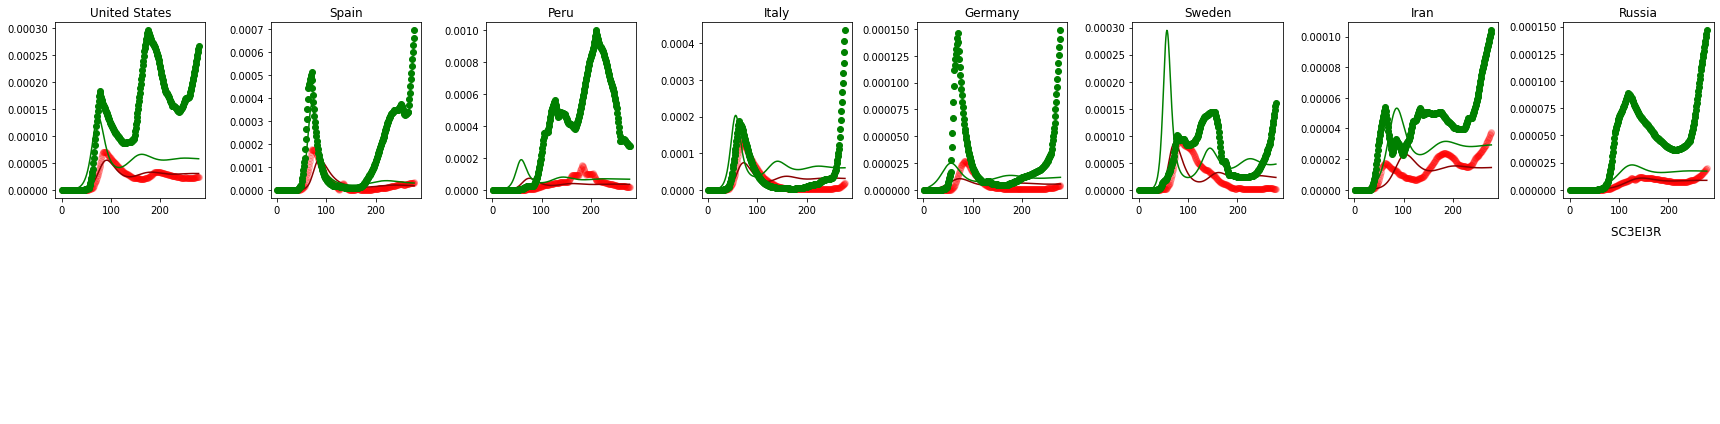

In [130]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,2.6*max_rows))

start = time()

# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        
        MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_scan",new=True,data_src='owid') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,fit_method='slsqp',diag=False,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])
        MyModel.solveplot(species=['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_nonlinr_corrected_smoothed'],axis=axes[row,col],newplot=False)       
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()
print('Elapsed time ',time()=start)

### country scan, cluster countries, death fit only.

0 Afghanistan
1 Albania
2 Algeria
3 Argentina
4 Armenia
5 Austria
6 Azerbaijan
7 Bahrain
8 Bangladesh
9 Belarus
10 Belgium
11 Bolivia
12 Bosnia and Herzegovina
13 Brazil
14 Bulgaria
15 Cameroon
16 Chile
17 Colombia
18 Costa Rica
19 Croatia
20 Czech Republic
21 Denmark
22 Dominican Republic
23 Ecuador
24 Egypt
25 El Salvador
26 Finland
27 France
28 Germany
29 Ghana
30 Greece
31 Guatemala
32 Haiti
33 Honduras
34 Hungary
35 India
36 Indonesia
37 Iran
38 Iraq
39 Ireland
40 Israel
41 Italy
42 Japan
43 Kazakhstan
44 Kenya
45 South Korea
46 Kosovo
47 Kuwait
48 Kyrgyzstan
49 Lebanon
50 Malaysia
51 Mexico
52 Moldova
53 Morocco
54 Netherlands
55 Macedonia
56 Norway
57 Oman
58 Pakistan
59 Panama
60 Paraguay
61 Peru
62 Philippines
63 Poland
64 Portugal
65 Qatar
66 Romania
67 Russia
68 Saudi Arabia
69 Senegal
70 Serbia
71 South Africa
72 Spain
73 Sudan
74 Sweden
75 Switzerland
76 Tunisia
77 Turkey
78 United States
79 Ukraine
80 United Arab Emirates
81 United Kingdom
82 Uzbekistan
83 Venezuela
84 Ye

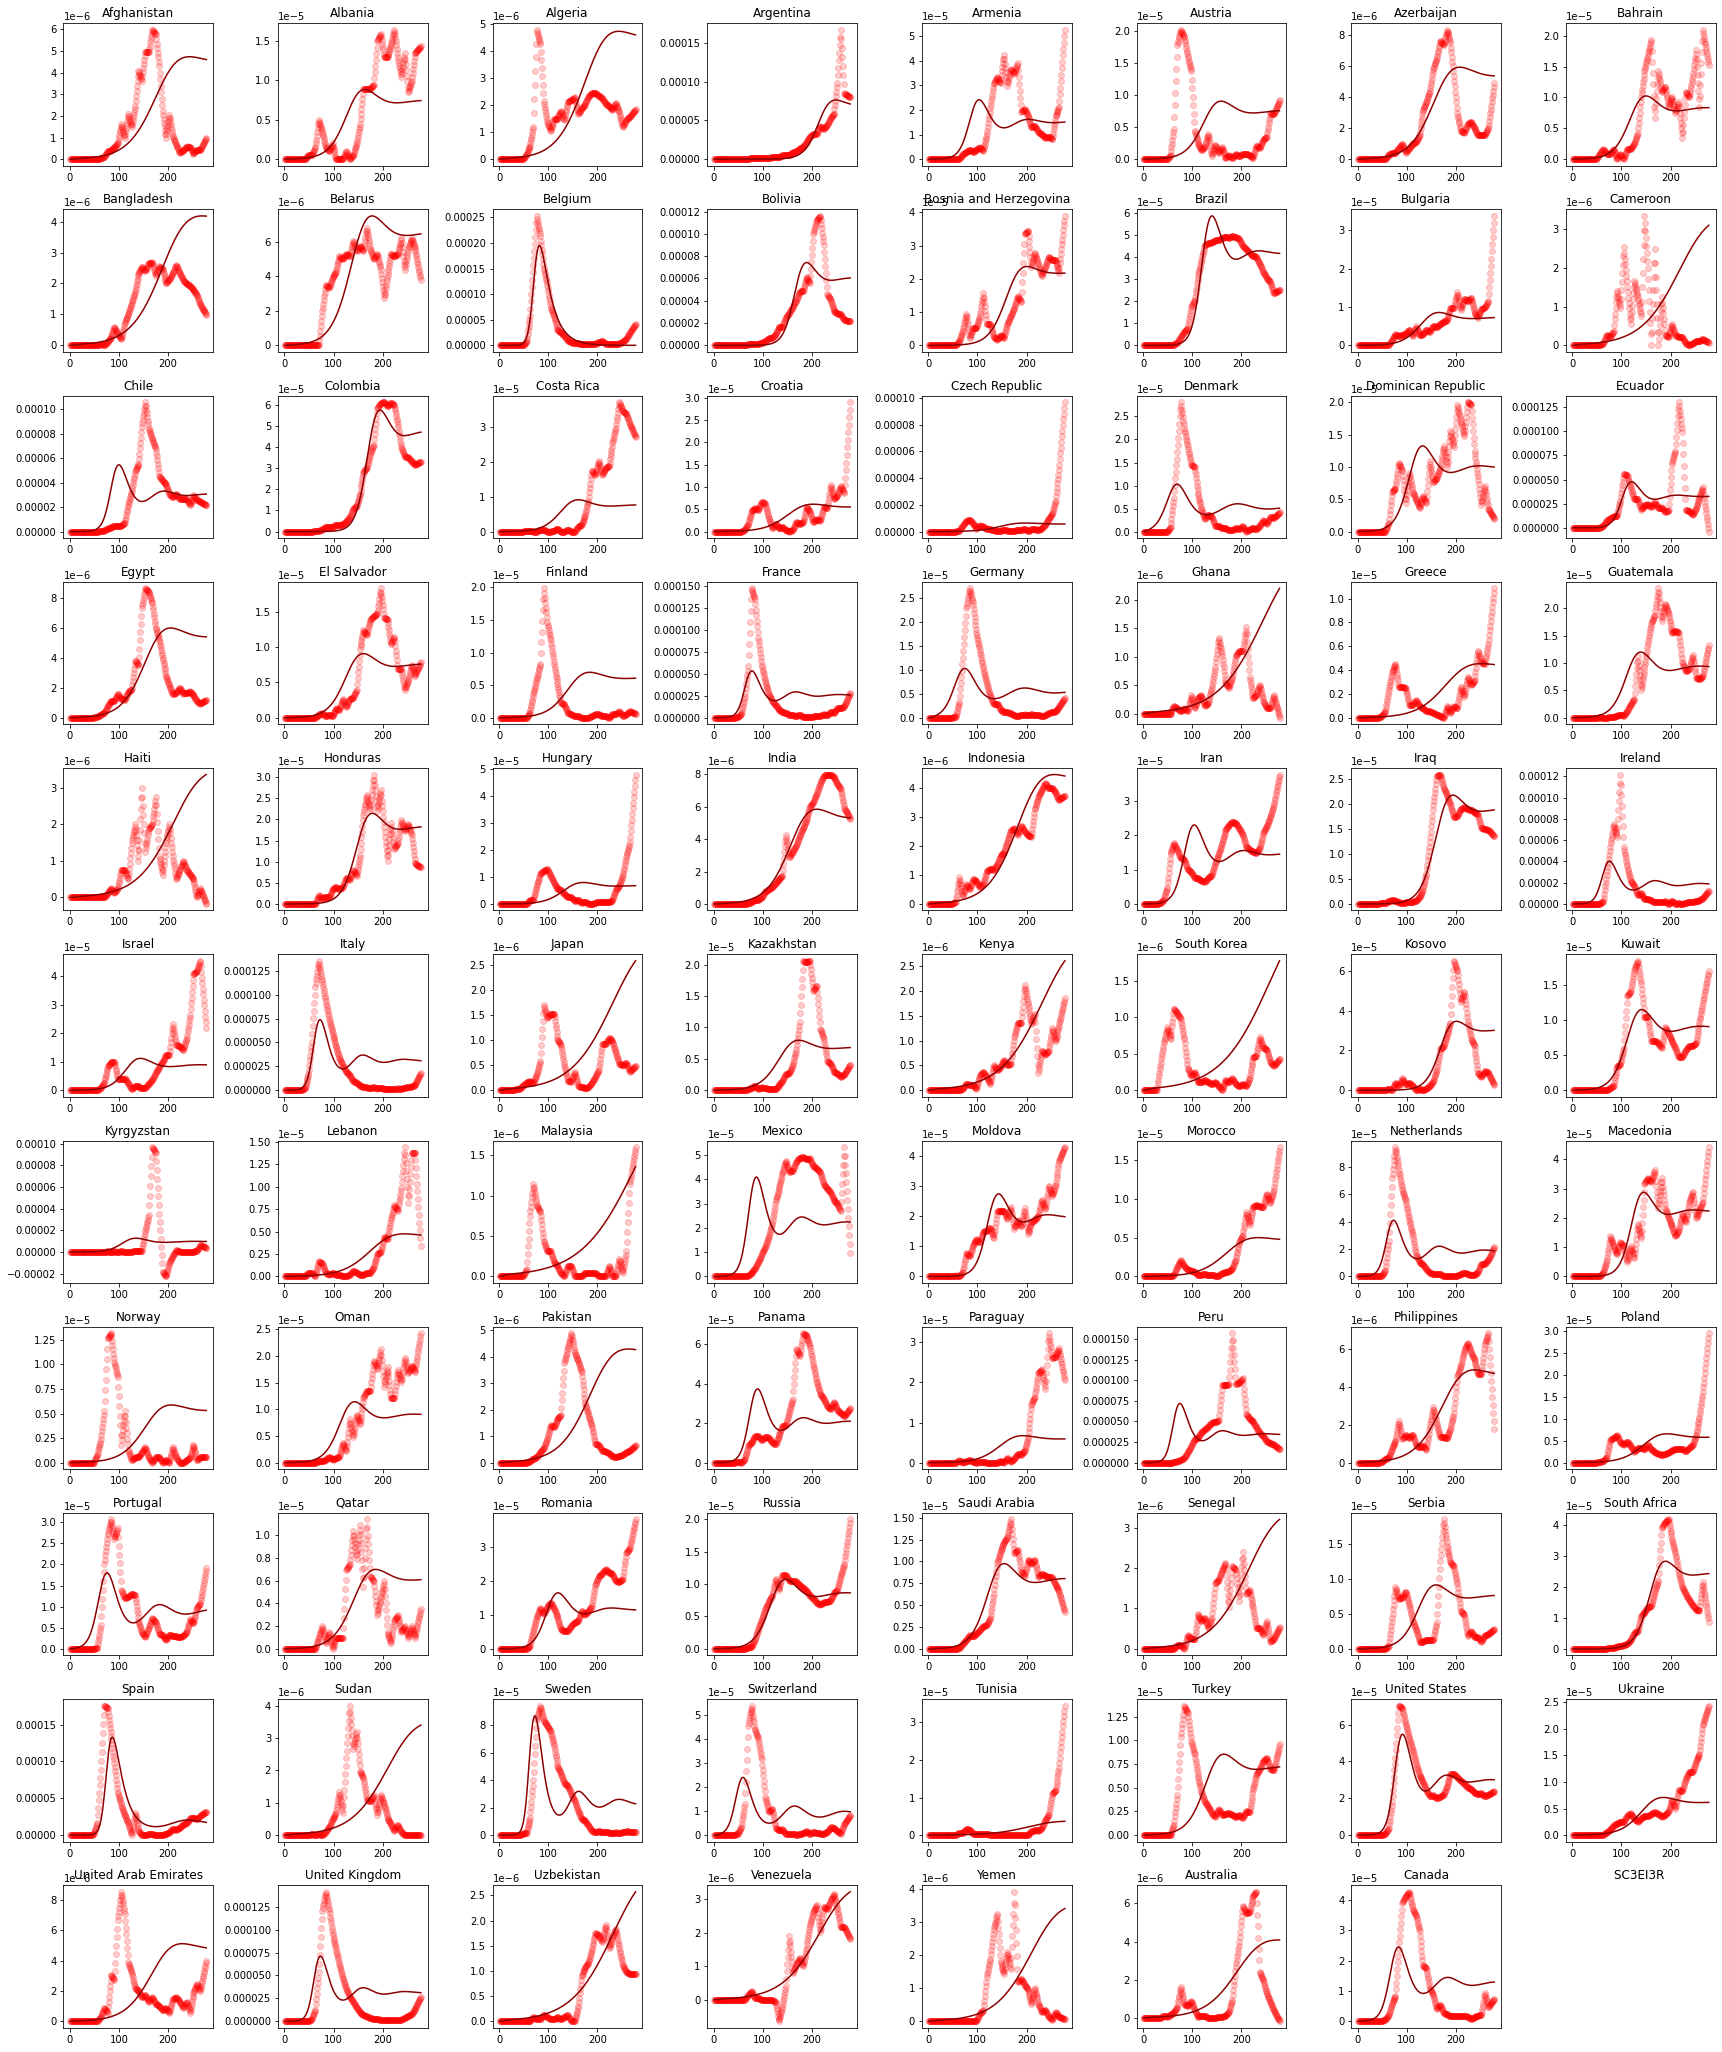

Elapsed time for  87 countries: 32576.480043172836


In [147]:

#countries = short_countries
countries = cluster_countries
cnt=0
max_cols=8
max_rows=int(len(countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,2.6*max_rows))

scan_params = {}
scan_fitdata = {}
start = time()
# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "logI_0": (-6.,-10.,0.0)}


#for idx, country  in enumerate(short_countries):
for idx, country  in enumerate(countries):
    print(idx,country)
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3EI3R',basedata=bd,data=bd.covid_owid_ts,country=country,run_id="_scan",new=True,data_src='owid') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,fit_method='slsqp',diag=False,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],report=False)
        MyModel.solveplot(species=['deaths'],datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)  
        scan_params[country] = MyModel.all_params
        scan_fitdata[country] = MyModel.fit_output
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3EI3R.pdf')
plt.show()
print('Elapsed time for ',len(countries),'countries:',time()-start)

In [148]:
scan_params['Germany']

{'params': {'beta_1': 0.24788523213977465,
  'beta_2': 0.0,
  'beta_3': 0.0,
  'alpha': 0.2,
  'gamma_1': 0.06999999999999999,
  'gamma_2': 0.16666666666666669,
  'gamma_3': 0.1,
  'p_1': 0.030000000000000013,
  'p_2': 0.08333333333333333,
  'mu': 0.091647226633305,
  'c_0': 0.08822340585636335,
  'c_1': 0.0384765022148435,
  'c_2': 5.901282657859958,
  'N': 1},
 'sbparams': {'Exposure': 0.4,
  'IncubPeriod': 5,
  'DurMildInf': 10,
  'FracMild': 0.7,
  'FracCritical': 0.1,
  'CFR': 0.05,
  'TimeICUDeath': 5,
  'DurHosp': 4,
  'ICUFrac': 0.001,
  'logI_0': -4.84018842946475},
 'fbparams': {'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0},
 'cbparams': {'CautionFactor': 0.1,
  'CautionRetention': 60.0,
  'CautionExposure': 0.1,
  'EconomicStriction': 30.0,
  'EconomicRetention': 60.0,
  'EconomyRelaxation': 60.0,
  'EconomicCostOfCaution': 0.5},
 'dbparams': {'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'},
 'initial_values': (array([9.99985552e-01, 0.00000000e+00, 1.44481

In [149]:
scan_fitdata['Germany']

In [157]:
run_id=MyModel.modelname+'_'+'_'.join(MyModel.fit_targets)+'_'+'owid'
run_id

'SC3EI3R_deaths_owid'

In [159]:
scan_all = {}
scan_all['params'] = scan_params.copy()
scan_all['fitdata'] = scan_fitdata.copy()
pk.dump(scan_all,open(run_id+'.pk','wb'))


## Try for U model class

In [ ]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3UEI3R',country=country,run_id="_test3")

In [ ]:
params_init_min_max = {"beta_1": (0.37526113317338305, 0., 2.,0.001),
                       "alpha": (0.2, 0., 1.,0.001),
                       "mu": (0.11549404287611789,0.,.2,0.001),
                       "c_0": (0.2583441976053431, 0., 1.0,0.001),
                       "c_1": (0.03763741590817468, 0.0, 0.5,0.001),
                       "c_2": (3.620445327728954, 2.,20.,0.01),
                       "k_u": (1.0/5.0,0,1,0.001),
                       "k_1": (1.0/90.0,0.0,1.0,0.001),
#                       "k_w": (1.0/90.0,0.0,1.0),
#                       "kappa": (0.5,0,1.0),
                       "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [ ]:
for pp in params_init_min_max:
    if pp in MyModel.params:
        print(pp,MyModel.params[pp],params_init_min_max[pp])
    

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

### slider plot

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [ ]:
MyModel.prparams()

### Country scan

In [ ]:
countries = [c for c in clusdata_all['deaths']]
len(countries)

In [ ]:
short_countries = ['United States','Spain','Peru','Italy','Germany','Sweden','Iran','Russia']

In [ ]:
MyModel = ModelFit('SC3UEI3R',country=short_countries[0],run_id="_scan")

In [ ]:
params_init_min_max = {"beta_1": (0.2, 0., 2.),
                       "mu": (.1,0.,.2),
                       "c_0": (0.1, 0., 1.0),
                       "c_1": (0.07, 0.0, 0.5),
                       "c_2": (5., 2.,20.),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}

In [ ]:
MyModel.fit(params_init_min_max,diag=False)

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])

In [ ]:
cnt=0
max_cols=8
max_rows=int(len(short_countries)/max_cols) + 1
# max_rows = 2   # for short test...
fig, axes = plt.subplots(nrows=max_rows, ncols=max_cols, figsize=(24,3*max_rows))


# params optimized in fit
params_init_min_max = {"beta_1": (0.2, 0.1, 0.5),
                       "mu": (.1,0.05,.2),
                       "c_0": (0.1, 0.05, 0.5),
                       "c_1": (0.07, 0.02, 0.2),
                       "c_2": (5., 2.,20.),
                       "k_u": (1.0/5.0,0,1),
                       "k_1": (1.0/90.0,0.0,1.0),
                       "k_w": (1.0/90.0,0.0,1.0),
                       "logI_0": (-6.,-10.,0.0)}


for idx, country  in enumerate(short_countries):
    row = idx // max_cols
    col = idx % max_cols
    ###############################################
    ## do the fit
    try:
        MyModel = ModelFit('SC3UEI3R',country=country,run_id="_scan",data_src='jhu') # run_id labels parameter dump files
        MyModel.fit(params_init_min_max,diag=False,fit_targets=['deaths'],fit_data='deaths_corrected_smoothed')
        MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'],axis=axes[row,col],newplot=False)
    except Exception as e:
        print('Problem...')
        print(sys.exc_info()[0])
        print(e)
    axes[row,col].set_title(country)
    cnt = cnt+1
    #if cnt==15:   # for short test
    #    break
    ###############################################

for idx in range(cnt,max_rows*max_cols):
    row = idx // max_cols
    col = idx % max_cols
    axes[row, col].axis("off")
#plt.subplots_adjust(wspace=.05, hspace=.05)
fig.tight_layout()
#for ax in fig.get_axes():
#    ax.label_outer()
plt.savefig('scan.SC3UEI3R.pdf')
plt.show()

# Pygom + minimize with sensitivities

## Previous pygom fitting example from `Caution_paper_Fitting`

In [ ]:
test_country = 'Germany'
fitdata = covid_ts['new_deaths_corrected_smoothed'][(test_country,'')]
t = list(range(len(fitdata)))

In [ ]:
plt.plot(fitdata);

In [ ]:
model = 'SC3UEI3R'
I_0 =  0.00003
x0_SC3UEI3R = [1.0-I_0, 0.0, I_0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
SC3UEI3R_model.initial_values = (x0_SC3UEI3R, t[0])

# Define parameters based on clinical observations Dr. Alison
Exposure=0.4 # Rate coefficient for exposure per individual in contact per day
IncubPeriod=5  #Incubation period, days
DurMildInf=8 #Duration of mild infections, days
FracMild=0.65  #Fraction of infections that are mild
FracSevere=0.20 #Fraction of infections that are severe
FracCritical=0.15 #Fraction of infections that are critical
CFR=0.1 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=4 #Time from ICU admission to death, days
DurHosp=5 #Duration of hospitalization, days

# Model fitting extension to allow for incomplete detection
FracConfirmedDet=0.5  # Fraction of recovered individuals measured
FracRecoveredDet=FracConfirmedDet # Fraction of recovered individuals measured
FracDeathsDet=1.0

# Model extension by John McCaskill to include caution 
CautionFactor= 0.1 # Fractional reduction of exposure rate for cautioned individuals
CautionRetention= 60. # Duration of cautionary state of susceptibles (2 weeks)
CautionICUFrac= 0.1 # Fraction of ICUs occupied leading to transition to caution @ 1/day
ICUFrac= 0.001 # Fraction of ICUs relative to population size N

# Model extension by John McCaskill to include economic influence on caution 
EconomicCostOfCaution= 0.5 # Fractional reduction of economic contribution for cautioned individuals

p = [0,(1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,  (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere))]
g = [0,(1.0/DurMildInf)*FracMild,   (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
           (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical)]
u = (1.0/TimeICUDeath)*(CFR/FracCritical)
                
params = {'beta_1' : Exposure/sum(x0_SC3UEI3R),
          'beta_2' : 0.0,
          'beta_3' : 0.0,
          'alpha' : 1.0/IncubPeriod,
          'gamma_1': (1.0/DurMildInf)*FracMild,
          'gamma_2': (1.0/DurHosp)-(1/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'gamma_3': (1.0/TimeICUDeath)-(1/TimeICUDeath)*(CFR/FracCritical),
          'p_1'    : (1.0/DurMildInf)-(1.0/DurMildInf)*FracMild,
          'p_2'    : (1.0/DurHosp)*(FracCritical/(FracCritical+FracSevere)),
          'mu'    : (1.0/TimeICUDeath)*(CFR/FracCritical),
          'c_0'    : CautionFactor,
          'c_1'    : 1.0/CautionRetention,
          'c_2'    : 1.0/(ICUFrac*CautionICUFrac),
          'k_u'    : 1.0/5.,
          'k_1'    : 1.0/90,
          'k_w'    : 1.0/90,
          'kappa'  : EconomicCostOfCaution,
          'N'      : sum(x0_SC3UEI3R)}

print(params)
SC3UEI3R_model.parameters = params.copy()

In [ ]:
SC3EI3R_model.parameters = {'beta_1': 0.4, 'beta_2': 0.0, 'beta_3': 0.0, 'alpha': 0.2, 'gamma_1': 0.06999999999999999, 'gamma_2': 0.16666666666666669, 'gamma_3': 0.1, 'p_1': 0.030000000000000013, 'p_2': 0.08333333333333333, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.016666666666666666, 'c_2': 10000.0, 'N': 1.0}

In [ ]:
np.shape(t)

In [ ]:
# Initial guess of parameters and initial condition, and bounding constraints
I0 =10**-7
x0_SC3EI3R = [1.-I0,0.,I0,0.,0.,0.,0.,0.,0.,0.]
SC3EI3R_model.parameters={'beta_1': 0.41, 'mu': 0.1, 'c_0': 0.1, 'c_1': 0.0166, 'c_2': 10000.0}
cautionparams = list(params.values())[-4:-1]
theta = [0.40,0.1,0.3,0.0167,1000.] # cautionparams
# boxBounds = [(0.2,0.5),(0.03,0.15),(0.3,0.5),(0.01,0.02),(6000.,12000.)]
boxBounds = [(0.2,0.5),(0.03,0.15),(0.3,0.5),(0.01,0.02),(600.,1200.)]
# set up optimization function with cost and sensitivity (Jacobian)
objSC3EI3R = SquareLoss(theta=theta, ode=SC3EI3R_model, x0=x0_SC3EI3R, t0=t[0], t=t[1::], y=fitdata[1:],
                      # state_weight=[1.,10.],state_name=['R','D'],
                        state_weight=[1.],state_name=['D'],
                        target_param=['beta_1','mu','c_0','c_1','c_2'],target_state=['I_1'])
# perform optimization
res = minimize(fun=objSC3EI3R.costIV,
                jac=objSC3EI3R.sensitivityIV,
                x0=theta+[I0],
                bounds=boxBounds+[(0.00000001,0.000001)],
                # method='BFGS',
                method='SLSQP',
                #options={'disp':True,'maxiter':1000,'eps':0.01,'gtol':0.01})
                #options={'disp':True})
                options={'disp':True,'maxiter':1000,'eps':0.01,'ftol':0.01})
print(res)

# Fitting base params

In [ ]:
[x for x in dir(MyModel) if 'param' in x]

In [ ]:
MyModel.prparams()


In [ ]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

## parameter setup for 3 rounds of fitting with standard values (use copy if want to edit)

In [ ]:
params_init_min_max_1 = {
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'CautionFactor': (0.1, 0.01, 1.0, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.1 , 0.01, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.2,1.0,0.001)
}

In [ ]:
params_init_min_max_1U = {
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'CautionFactor': (0.1, 0.01, 1.0, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.1 , 0.01, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.2,1.0,0.001)
}

In [ ]:
params_init_min_max_2 = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.3,1.0,0.001)
}

In [ ]:
params_init_min_max_2U = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.3,1.0,0.001),
    'EconomicRetention': (60,15,90,0.01)
}

In [ ]:
params_init_min_max_3 = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'IncubPeriod': (5, 2, 7, 0.01),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.25,1.0,0.001)
}

In [ ]:
params_init_min_max_3U = {
    'FracMild': (0.7,0.6,0.85,0.001),
    'FracCritical': (0.1,0.05,0.15,0.001),
    'CFR': (0.05, 0.03,0.1,0.001),
    'DurHosp': (4, 2, 8, 0.01),
    'DurMildInf': (10, 5, 20, 0.01),
    'Exposure': (0.4, .05, 1.0, 0.001),
    'logI_0': (np.log10(0.0000003), -10. ,-4. , 0.001),
    'IncubPeriod': (5, 2, 7, 0.01),
    'TimeICUDeath': (5, 2, 7, 0.01),
    'CautionFactor': (0.2, 0.1, 0.3, 0.001),
    'CautionRetention': (60 , 15, 90, 0.01 ),
    'CautionExposure': (0.2 , 0.1, 1., 0.001 ),
    'FracConfirmedDet':(0.5,0.1,1.0,0.001),
    'FracDeathsDet':(1,0.25,1.0,0.001),
    'EconomicRetention': (60,15,90,0.01),
    'EconomicStriction': (30,15,90,0.01),
    'EconomicRelaxation': (60,15,90,0.01),
    'EconomicCostOfCaution': (0.5,0.1,0.9,0.001)
}

## Example Germany

In [ ]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test3")

In [ ]:
MyModel.fit(params_init_min_max_1,param_class='base', fit_method='leastsq',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

In [ ]:
# the optimized parameters from stage 1 are transferred to initial values for these parameters
# in the larger set of parameters in stage 2
params_init_min_max_2 = MyModel.transfer_fit_to_params_init(params_init_min_max_2)
MyModel.fit(params_init_min_max_2,param_class='base', fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

### Death only

In [ ]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test4")

In [ ]:
MyModel.fit(params_init_min_max_1,param_class='base', fit_method='leastsq',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])

In [ ]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

In [ ]:
# the optimized parameters from stage 1 are transferred to initial values for these parameters
# in the larger set of parameters in stage 2
params_init_min_max_2 = MyModel.transfer_fit_to_params_init(params_init_min_max_2)
MyModel.fit(params_init_min_max_2,param_class='base', fit_method='nelder',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'])
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

In [ ]:
plt.semilogy(MyModel.residall);

### slider plot for base params

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max_2)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('base'),**sliderparams)
    display(w)

In [ ]:
params_init_min_max_2_slider = params_init_min_max_2.copy()
params_init_min_max_2_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_2_slider)

In [ ]:
MyModel.prparams()

### slider plot for ode params

In [ ]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [ ]:
# define with 4th tuple elt step size for sliders
params_init_min_max = {"beta_1": (0.487, 0., 1., 0.001),
                       "alpha": (0.2,0.,1.,0.001),
                       "mu": (0.057,0.,.2,0.001),
                       "c_0": (0.1, 0., 1.0,0.001),
                       "c_1": (0.011, 0.0, 0.5,0.001),
                       "c_2": (4.15, 2.,20.,0.01),
                       "logI_0": (-6.85,-10.,0.0, 0.01)}

In [ ]:
sliderparams = MyModel.allsliderparams(params_init_min_max)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

In [ ]:
MyModel.prparams()